## i. Introduction
Marchelly Gideon Tambunan

- [DATASET](https://www.kaggle.com/datasets/jehanbhathena/weather-dataset)
- [DEPLOYMENT](https://huggingface.co/spaces/gdntmbnn/weather-image-prediction)
- OBJECTIVE: Make a weather prediction based on photo

# ii. Import Libraries

In [9]:
#For Data Manipulation
import numpy as np
import pandas as pd
from IPython.display import clear_output

#For Visualization
import matplotlib.pyplot as plt 
import seaborn as sns

# For Modeling Artificial Neural Network
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
import splitfolders
import cv2
import os

#For Model Evaluation 
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix, roc_auc_score

#Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

#Set random seed
np.random.seed(711)
tf.random.set_seed(711)

# iii. Data Loading

### Setting GPU for Tensorflow

In [10]:
print('GPU: {}'.format(len(tf.config.list_physical_devices('GPU'))))

GPU: 1


### Splitting Data to Train, Val, Test Folder

In [11]:
splitfolders.ratio("dataset", output="dataset-output", seed=711, ratio=(0.8,0.1,0.1), group_prefix=None)

Copying files: 6862 files [00:03, 2043.77 files/s]


### Input the file into dataframe

In [12]:
df_total = {'dew': [698], 'fogsmog': [851],'frost': [475], 'glaze': [639],'hail': [591], 'lightning': [377],
            'rain': [526], 'rainbow': [232],'rime': [1160], 'sandstorm': [692],'snow': [621]}
df_total = pd.DataFrame(data=df_total)

After we split and input to dataframe, we want to check total value and class of train data

In [13]:
dew_train= r'dataset-output\train\dew'
fogsmog_train= r'dataset-output/train/fogsmog'
frost_train= r'dataset-output/train/frost'
glaze_train= r'dataset-output/train/glaze'
hail_train= r'dataset-output/train/hail'
lightning_train= r'dataset-output/train/lightning'
rain_train= r'dataset-output/train/rain'
rainbow_train= r'dataset-output/train/rainbow'
rime_train= r'dataset-output/train/rime'
sandstorm_train= r'dataset-output/train/sandstorm'
snow_train= r'dataset-output/train/snow'
dirlist=[dew_train, fogsmog_train, frost_train, glaze_train, hail_train, lightning_train, rain_train, rainbow_train,
         rime_train, sandstorm_train, snow_train]
classes=['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']
filepaths=[]
labels=[]
for d,c in zip(dirlist, classes):
    flist=os.listdir(d)
    for f in flist:
        fpath=os.path.join (d,f)
        filepaths.append(fpath)
        labels.append(c)
print ('filepaths: ', len(filepaths), '   classes: ', len(classes))

filepaths:  5484    classes:  11


# iv. Exploratory Data Analysis(EDA)

In this section we want to make some exploration to understand about the data

In [14]:
Fseries=pd.Series(filepaths, name='file_paths')
Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries,Lseries], axis=1)

In [15]:
df=pd.DataFrame(np.array(df).reshape(5484,2), columns = ['file_paths', 'labels'])
print(df['labels'].value_counts())

rime         928
fogsmog      680
dew          558
sandstorm    553
glaze        511
snow         496
hail         472
rain         420
frost        380
lightning    301
rainbow      185
Name: labels, dtype: int64


Here we can see that the data has `11` type of weather

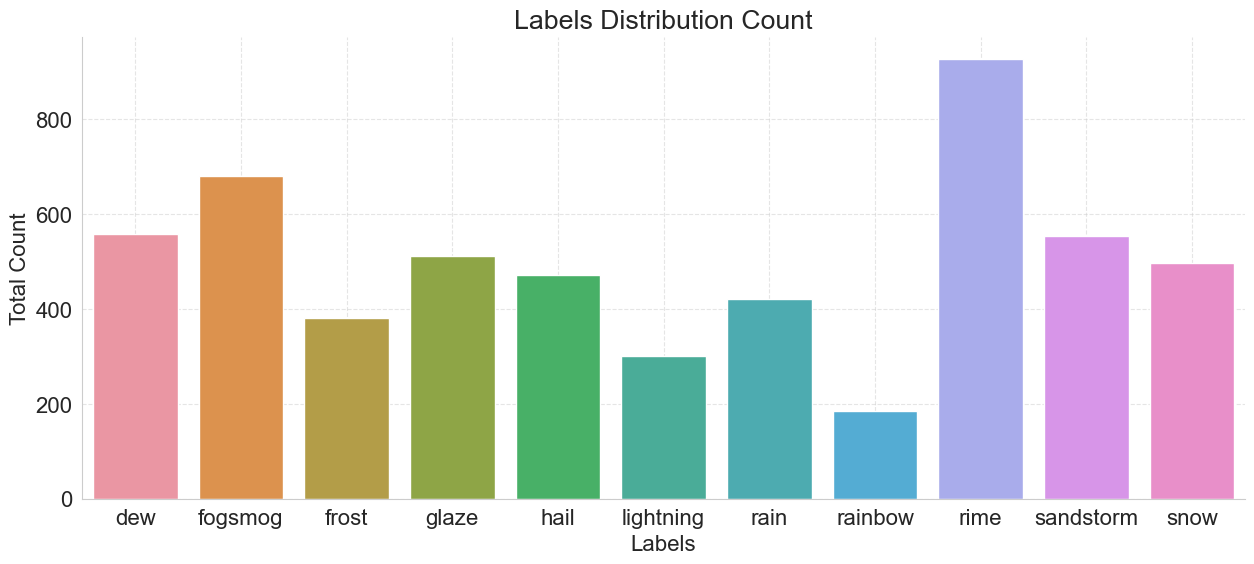

In [16]:
# Set seaborn style and palette
sns.set_style('whitegrid')
sns.set_palette('pastel')

# Set font size
plt.rcParams.update({'font.size': 16})

# Create figure and plot
fig = plt.figure(figsize=(15, 6))
ax = sns.countplot(x='labels', data=df)
ax.set_title('Labels Distribution Count')
ax.set_xlabel('Labels')
ax.set_ylabel('Total Count')

# Customize grid
ax.grid(True, linestyle='--', alpha=0.5)

# Remove spines
sns.despine()

# Show plot
plt.show()


From our visualization, we can see that the data is imbalance. i think that's normal because we has so many tyoe of weather, so we don't need to handling the imbalance

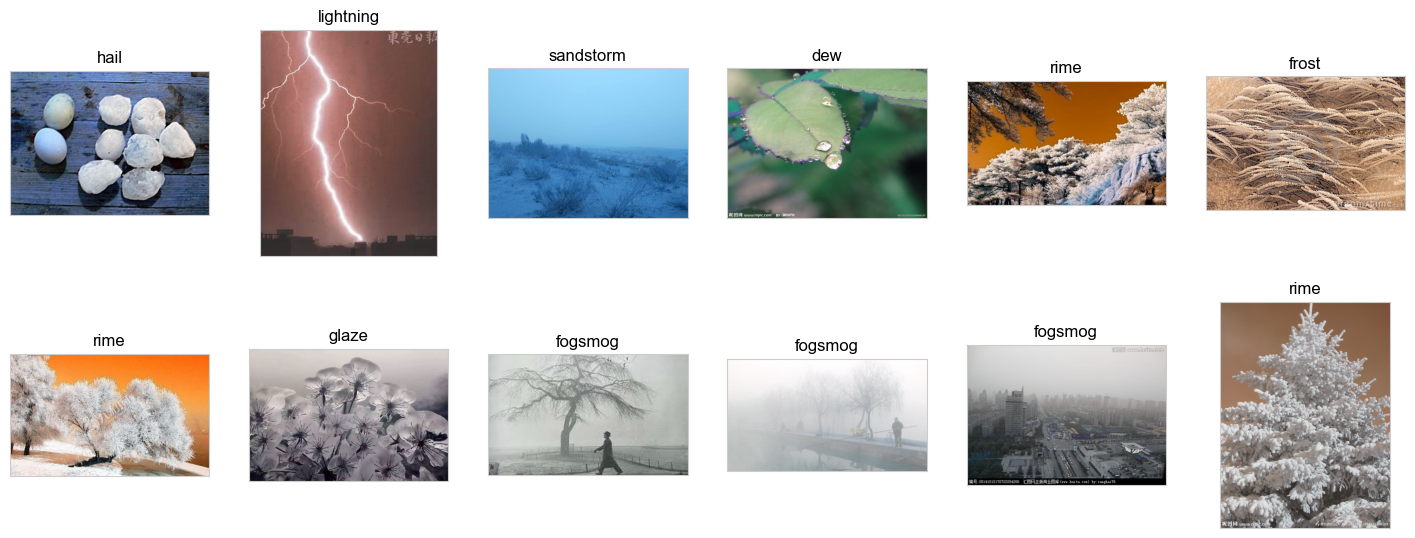

In [17]:
# Show our image data
plt.figure(figsize=(18,10))
for i in range(12):
    random = np.random.randint(1,len(df))
    plt.subplot(3,6,i+1)
    plt.imshow(cv2.imread(df.loc[random,"file_paths"]))
    plt.title(df.loc[random, "labels"], size = 12, color = "black") 
    plt.xticks([])
    plt.yticks([])

plt.show()

here we can see that the image has on the same folder

# v. Feature Engineering

In this step, we need to define the path

In [18]:
train_path = r"C:\H8_project\milestone\P2M2\dataset-output\train"
test_path = "dataset-output/test"
val_path = r"C:\H8_project\milestone\P2M2\dataset-output\val"

In [19]:
data_dir = 'C:\H8_project\milestone\P2M2\dataset'
class_names = ['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']
# create a pandas DataFrame with image filenames and labels
data = pd.DataFrame(columns=['images', 'label'])
for class_name in class_names:
    class_dir = os.path.join(data_dir, class_name)
    for filename in os.listdir(class_dir):
        filepath = os.path.join(class_dir, filename)
        data = data.append({'images': filepath, 'label': class_names.index(class_name)}, ignore_index=True)
# convert integer labels to string using map method
data['label'] = data['label'].map(lambda x: class_names[x])

### Data augmentation and rescaling

In [20]:
BATCH_SIZE = 32
IMG_SIZE = (256, 256)
augmentation_gen = ImageDataGenerator(
    rotation_range=120,
    zoom_range=[0.7, 1.5],
    shear_range=50,
    validation_split=0.3
)

train_set = augmentation_gen.flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_set = augmentation_gen.flow_from_directory(
    val_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

test_gen = ImageDataGenerator(rescale=1/255.)
test_set = test_gen.flow_from_directory(
    test_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 3843 images belonging to 11 classes.
Found 198 images belonging to 11 classes.
Found 696 images belonging to 11 classes.


here we can see that the data of train, test, val

Found 4804 validated image filenames belonging to 11 classes.


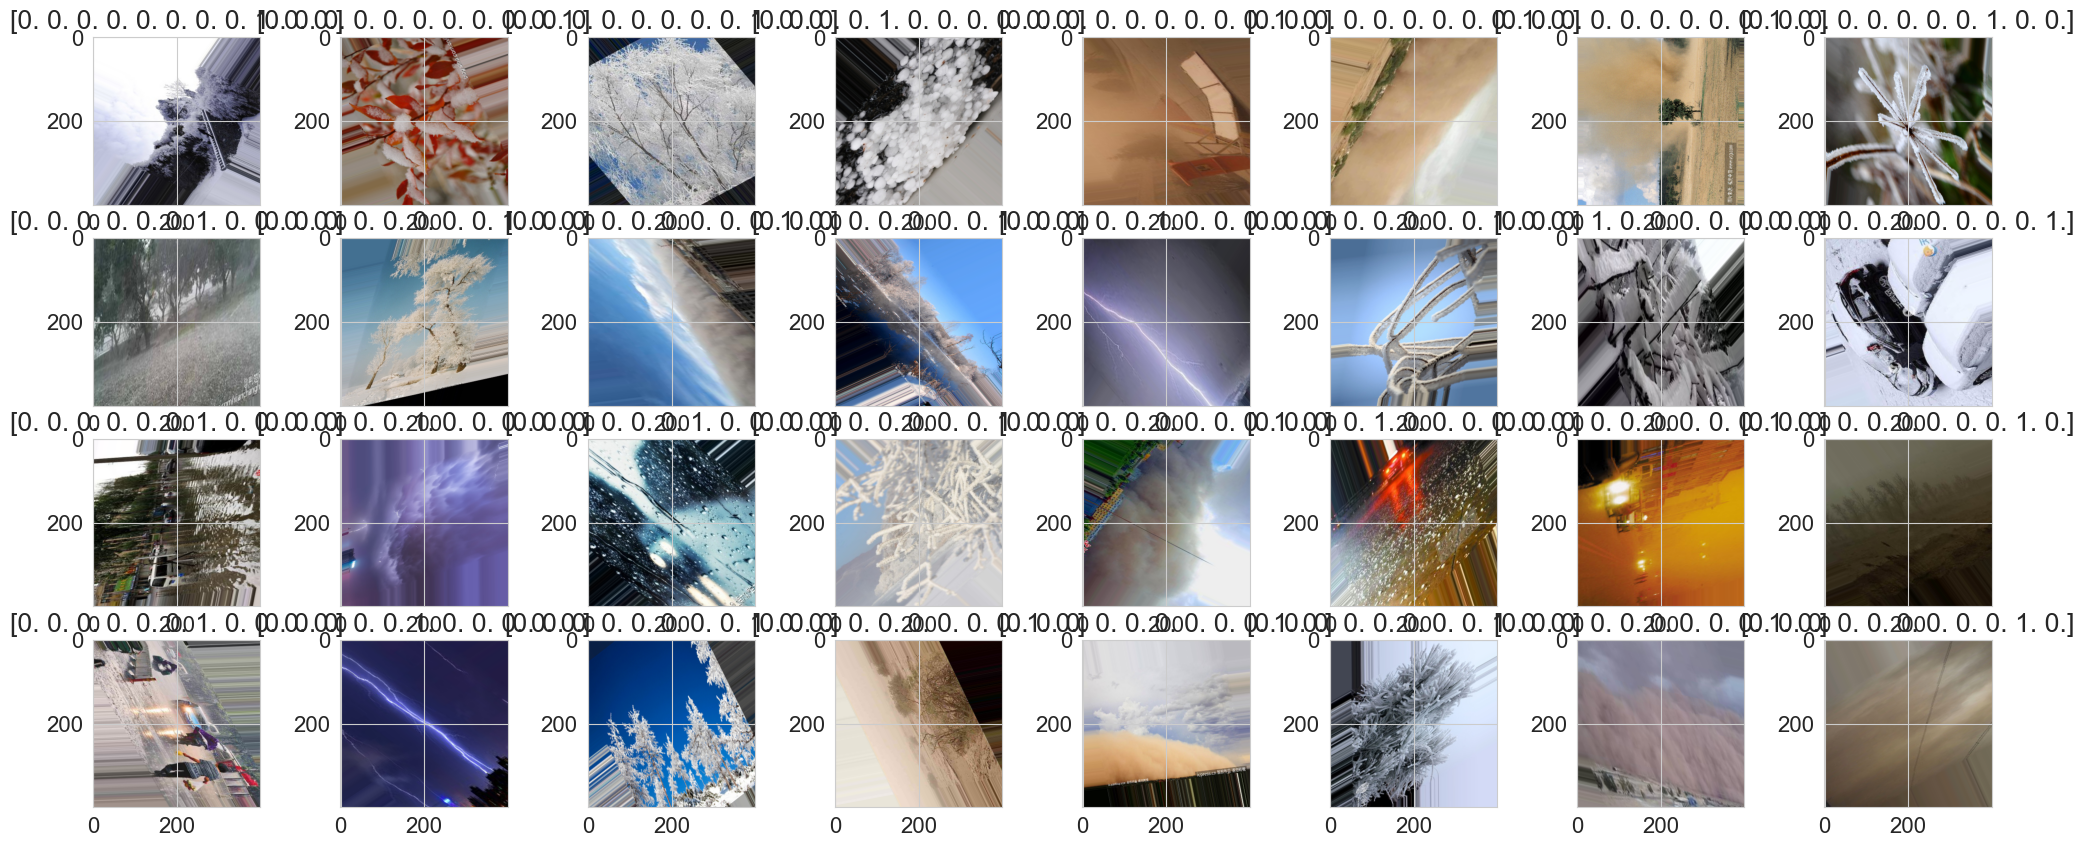

In [21]:
# use the DataFrame with the flow_from_dataframe method
train_viz = augmentation_gen.flow_from_dataframe(
    data,
    x_col='images',
    y_col='label',
    target_size=(400, 400),
    class_mode='categorical',
    subset='training',
    shuffle=True
)

## visualize the images
fig, ax = plt.subplots(nrows=4, ncols=8, figsize=(25, 10))
n = 0
for i in range(4):
    for j in range(8):
        images, labels = next(train_viz)
        img = images[0].astype('uint8')
        ax[i][j].imshow(img)
        ax[i][j].set_title(labels[0])

here the visualization about our augmented data.

# v. Model Definition

Here we will define our model for this project, We use CNN with some baseline model. We will also make a improved model using a pre-trained model.

### Base Model

Now we will build our model. Here we use (256,256, 3) to be our input which shows that we have RGB image.

In [22]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])
image_batch, label_batch = next(iter(train_set))
feature_batch = preprocess_input(image_batch)
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
inputs = tf.keras.Input(shape=(256, 256, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = data_augmentation(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)
base_learning_rate = 0.0001


In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 256, 256, 3)  0           ['input_1[0][0]',                
                                                                  'tf.math.subtract[0][0]']       
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 256, 256, 3)  0           ['sequential[0][0]']             
                                                                                              

In [24]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Base Model Training

In [25]:
initial_epochs = 25
model_fit = model.fit(train_set,
                    epochs= initial_epochs,
                    validation_data= val_set)

Epoch 1/25
121/121 [==============================] - 50s 407ms/step - loss: 0.7164 - accuracy: 0.7914 - val_loss: 0.6995 - val_accuracy: 0.8140
Epoch 2/25
121/121 [==============================] - 51s 423ms/step - loss: 0.7104 - accuracy: 0.7937 - val_loss: 0.6908 - val_accuracy: 0.8182
Epoch 3/25
121/121 [==============================] - 49s 402ms/step - loss: 0.7048 - accuracy: 0.7986 - val_loss: 0.6912 - val_accuracy: 0.8140
Epoch 4/25
121/121 [==============================] - 48s 395ms/step - loss: 0.7026 - accuracy: 0.7960 - val_loss: 0.6784 - val_accuracy: 0.8347
Epoch 5/25
121/121 [==============================] - 48s 396ms/step - loss: 0.6964 - accuracy: 0.8067 - val_loss: 0.6770 - val_accuracy: 0.8264
Epoch 6/25
121/121 [==============================] - 48s 402ms/step - loss: 0.6916 - accuracy: 0.8109 - val_loss: 0.6723 - val_accuracy: 0.8512
Epoch 7/25
121/121 [==============================] - 48s 399ms/step - loss: 0.6880 - accuracy: 0.8143 - val_loss: 0.6692 - val_ac

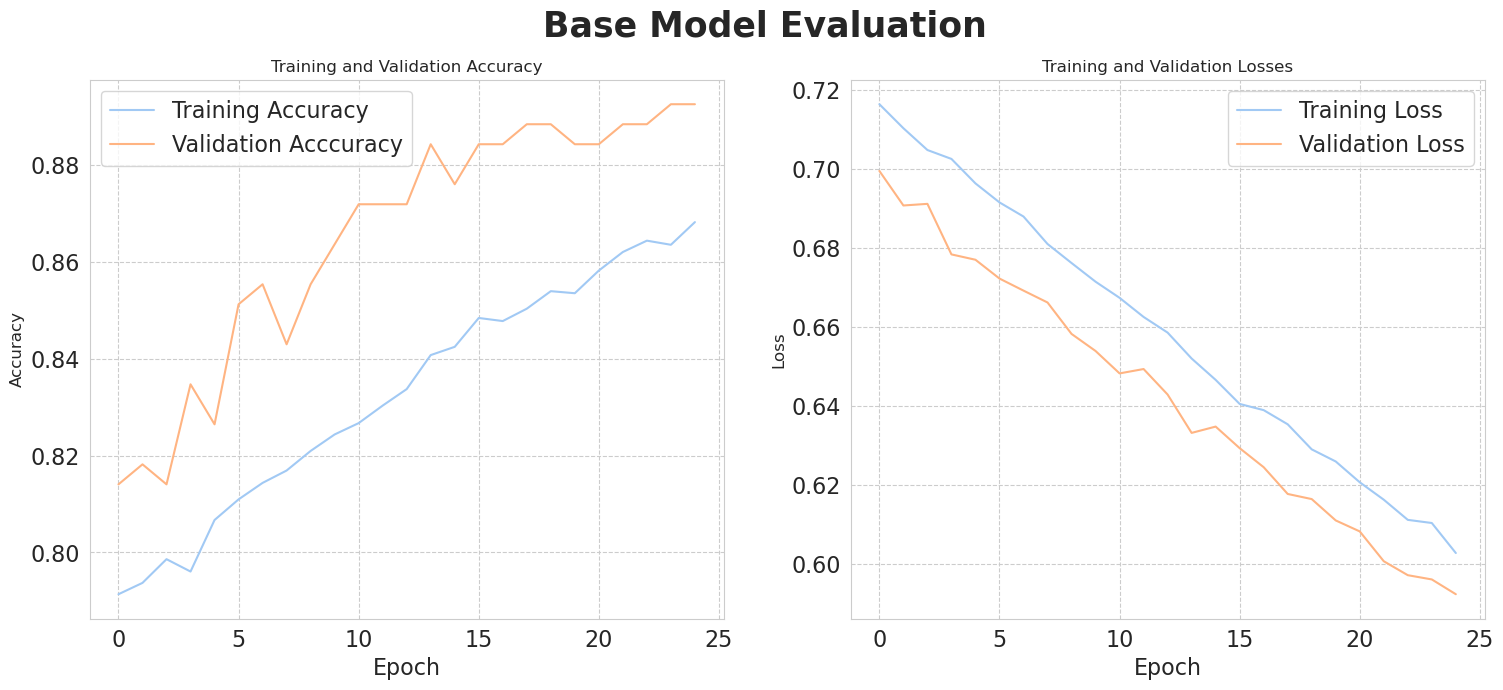

In [26]:
fig, ax = plt.subplots(1,2, figsize=(18,7))
fig.suptitle('Base Model Evaluation', fontsize=25, weight='bold')

plt.subplot(1,2,1)
plt.title("Training and Validation Accuracy", fontsize=12)
plt.plot(model_fit.history['accuracy'],label="Training Accuracy")
plt.plot(model_fit.history['val_accuracy'], label="Validation Acccuracy")
plt.ylabel("Accuracy", fontsize=12)
plt.xlabel('Epoch')
plt.legend()
plt.grid(linestyle='--')

plt.subplot(1,2,2)
plt.title("Training and Validation Losses", fontsize=12)
plt.plot(model_fit.history['loss'], label="Training Loss")
plt.plot(model_fit.history['val_loss'], label="Validation Loss")
plt.ylabel("Loss", fontsize=12)
plt.xlabel('Epoch')
plt.legend()
plt.grid(linestyle='--')

plt.style.use('default')
plt.show()

here we can see that the model is not good for our predict. we will doing some improvement by using same model with small parameter

### Improve Model

here we will add some parameter on MobileNetV2

In [27]:
mnet_model = tf.keras.applications.MobileNetV2(
    input_shape=(256,256,3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
mnet_model.trainable = False

In [28]:
model_tuned = tf.keras.Sequential([
    mnet_model,
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(11, activation='softmax')
])

model_tuned.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dense_1 (Dense)             (None, 512)               655872    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 11)                2827      
                                                                 
Total params: 3,048,011
Trainable params: 790,027
Non-trainable params: 2,257,984
______________________________________

In [29]:
model_tuned.compile(
    optimizer=tf.keras.optimizers.Adamax(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

After that we add earlystop to make the model learn based on the best score

In [30]:
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [31]:
history2 = model_tuned.fit(train_set, epochs=50, validation_data=val_set, callbacks=[earlystop])

Epoch 1/50
121/121 [==============================] - 52s 401ms/step - loss: 1.7574 - accuracy: 0.3765 - val_loss: 1.4914 - val_accuracy: 0.4495
Epoch 2/50
121/121 [==============================] - 48s 393ms/step - loss: 1.5133 - accuracy: 0.4697 - val_loss: 1.4636 - val_accuracy: 0.4697
Epoch 3/50
121/121 [==============================] - 49s 404ms/step - loss: 1.4303 - accuracy: 0.4993 - val_loss: 1.3313 - val_accuracy: 0.5455
Epoch 4/50
121/121 [==============================] - 47s 388ms/step - loss: 1.3700 - accuracy: 0.5087 - val_loss: 1.3187 - val_accuracy: 0.5556
Epoch 5/50
121/121 [==============================] - 47s 392ms/step - loss: 1.3094 - accuracy: 0.5441 - val_loss: 1.4011 - val_accuracy: 0.5455
Epoch 6/50
121/121 [==============================] - 47s 387ms/step - loss: 1.2711 - accuracy: 0.5566 - val_loss: 1.2599 - val_accuracy: 0.6061
Epoch 7/50
121/121 [==============================] - 47s 390ms/step - loss: 1.2593 - accuracy: 0.5563 - val_loss: 1.2865 - val_ac

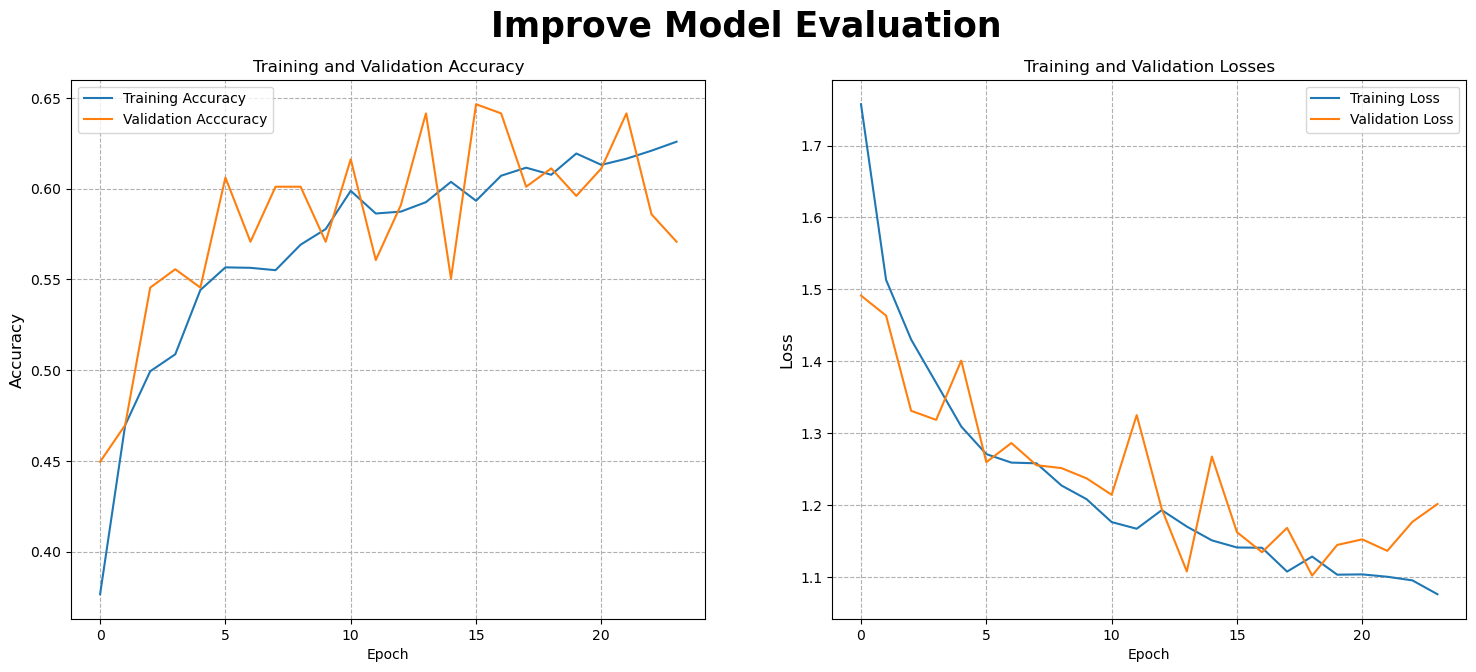

In [32]:
fig, ax = plt.subplots(1,2, figsize=(18,7))
fig.suptitle('Improve Model Evaluation', fontsize=25, weight='bold')

plt.subplot(1,2,1)
plt.title("Training and Validation Accuracy", fontsize=12)
plt.plot(history2.history['accuracy'],label="Training Accuracy")
plt.plot(history2.history['val_accuracy'], label="Validation Acccuracy")
plt.ylabel("Accuracy", fontsize=12)
plt.xlabel('Epoch')
plt.legend()
plt.grid(linestyle='--')

plt.subplot(1,2,2)
plt.title("Training and Validation Losses", fontsize=12)
plt.plot(history2.history['loss'], label="Training Loss")
plt.plot(history2.history['val_loss'], label="Validation Loss")
plt.ylabel("Loss", fontsize=12)
plt.xlabel('Epoch')
plt.legend()
plt.grid(linestyle='--')

plt.style.use('default')
plt.show()

here it is, the model is goodfit although can't gain high accuracy. but, i think it still can make predict of our data

# vi. Model Evaluation

In [33]:
prob = model_tuned.predict(test_set)
predictions = np.argmax(prob, axis=1)
true_labels = test_set.labels
print(classification_report(true_labels, predictions))
print('AUC Score:', roc_auc_score(true_labels, prob, multi_class='ovr'))

22/22 [==============================] - 3s 128ms/step
              precision    recall  f1-score   support

           0       0.24      0.34      0.28        71
           1       0.12      0.02      0.04        86
           2       0.00      0.00      0.00        48
           3       0.00      0.00      0.00        65
           4       1.00      0.02      0.03        60
           5       0.07      0.95      0.12        39
           6       0.00      0.00      0.00        54
           7       0.00      0.00      0.00        24
           8       0.00      0.00      0.00       116
           9       0.45      0.14      0.22        70
          10       0.00      0.00      0.00        63

    accuracy                           0.11       696
   macro avg       0.17      0.13      0.06       696
weighted avg       0.17      0.11      0.07       696

AUC Score: 0.6315372736598138


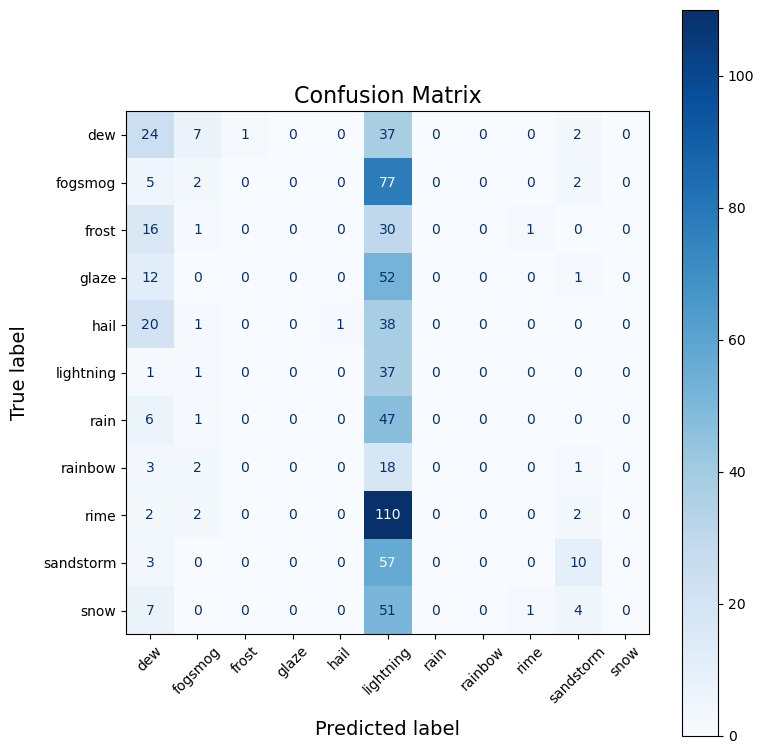

In [34]:
# Calculate confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Define class names
class_names = test_set.class_indices.keys()

# Create confusion matrix plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names)

fig, ax = plt.subplots(figsize=(8, 8))

# Customize plot
disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='.0f')
ax.grid(False)
ax.set_xlabel('Predicted label', fontsize=14, labelpad=10)
ax.set_ylabel('True label', fontsize=14, labelpad=10)

# Rotate x-axis tick labels by 45 degrees
ax.tick_params(axis='x', rotation=45)

# Add title
plt.title("Confusion Matrix", fontsize=16)

# Show plot
plt.tight_layout()
plt.show()


# vii. Model Saving

In [35]:
model_tuned.save('model.h5')

# viii. Conclusion

From this project, we coclude that:
- Our Base model has high accuracy on validation, but get lower accuracy on train
- On improving model, our model get a good fit, but the score is still not good.
- We use transfer learn because transfer learn can make highest score with good computation.
- weakness of this model is still got exploding gradient.
- Improved model has a faster train time.
- In our preprocessing we make our data input into (128,128,3), this was done to prevent a problems because of our hardware limitation.

Further Improvement:
- Make pretrained model for learning about the data
- Using different model to know how good the model is
- Making architecture with layer combination, neuron, and parameter to gain the model with good performance
